In [252]:
import sys
import numpy as np
import pandas as pd
import sklearn
import tensorflow
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels import api
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier

warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.3f}'.format

dir_data = "G:/내 드라이브/kamp/data"

randomSt = 24

## 데이터 전처리와 EDA

In [2]:
print("Python version :", sys.version)
print("numpy version :", np.__version__)
print("pandas version :", pd.__version__)
print("sklearn version :", sklearn.__version__)
print("tensorflow version :", tensorflow.__version__)

Python version : 3.11.3 | packaged by Anaconda, Inc. | (main, May 15 2023, 15:41:31) [MSC v.1916 64 bit (AMD64)]
numpy version : 1.24.3
pandas version : 2.0.3
sklearn version : 1.2.0
tensorflow version : 2.13.0


In [3]:
df = pd.read_csv(dir_data+"/data.csv", encoding="cp949")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939722 entries, 0 to 2939721
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   TAG_MIN            object 
 1   배정번호               int64  
 2   건조 1존 OP           float64
 3   건조 2존 OP           float64
 4   건조로 온도 1 Zone      float64
 5   건조로 온도 2 Zone      float64
 6   세정기                float64
 7   소입1존 OP            float64
 8   소입2존 OP            float64
 9   소입3존 OP            float64
 10  소입4존 OP            float64
 11  소입로 CP 값           float64
 12  소입로 CP 모니터 값       float64
 13  소입로 온도 1 Zone      float64
 14  소입로 온도 2 Zone      float64
 15  소입로 온도 3 Zone      float64
 16  소입로 온도 4 Zone      float64
 17  솔트 컨베이어 온도 1 Zone  float64
 18  솔트 컨베이어 온도 2 Zone  float64
 19  솔트조 온도 1 Zone      float64
 20  솔트조 온도 2 Zone      float64
dtypes: float64(19), int64(1), object(1)
memory usage: 471.0+ MB


,TAG_MIN,배정번호,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,...,소입로 CP 값,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
0,2022-01-03 11:22:07,102410,75.665,30.015,NaN,NaN,68.439,72.840,59.786,51.717,...,0.450,NaN,NaN,859.854,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-03 11:22:08,102410,75.671,32.273,NaN,NaN,68.439,78.442,61.629,50.445,...,0.450,0.000,860.338,859.780,860.044,859.786,294.658,272.538,328.734,328.865
2,2022-01-03 11:22:09,102410,75.678,32.159,98.853,99.146,68.439,78.110,61.541,52.020,...,0.450,0.000,860.338,859.780,859.981,859.724,294.658,272.538,328.734,328.805
3,2022-01-03 11:22:11,102410,75.866,30.831,98.792,99.177,68.500,77.507,60.666,52.694,...,0.450,0.000,860.338,859.842,859.950,859.599,294.719,272.538,328.674,328.865
4,2022-01-03 11:22:12,102410,73.647,29.527,98.792,99.207,68.439,76.026,61.163,51.691,...,0.450,0.000,860.351,859.791,859.991,859.731,294.721,272.599,328.740,328.808


In [4]:
df.describe()

,배정번호,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,소입4존 OP,소입로 CP 값,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
count,2939722.000,2939721.000,2939721.000,2939606.000,2939574.000,2939631.000,2935434.000,2939722.000,2939720.000,2939719.000,2939721.000,2939575.000,2939592.000,2939594.000,2939565.000,2939552.000,2939616.000,2939580.000,2939513.000,2939519.000
mean,128442.246,69.894,20.447,100.006,100.020,67.719,75.644,54.862,53.860,71.089,0.449,0.000,859.208,860.002,860.003,860.006,283.996,279.929,331.806,332.177
std,12637.044,4.015,5.217,0.436,0.362,1.631,25.161,4.429,2.664,2.557,0.019,0.000,3.648,0.558,0.352,0.455,9.513,6.612,0.783,0.873
min,102410.000,47.253,0.000,97.342,97.871,60.624,0.001,8.620,0.044,0.006,0.005,0.000,840.298,855.929,858.280,857.992,266.230,266.426,328.161,328.073
25%,119448.000,68.429,18.918,99.814,99.890,66.569,64.963,53.326,52.389,69.678,0.448,0.000,857.949,859.776,859.829,859.843,274.754,273.502,331.867,332.178
50%,129889.000,70.517,21.293,100.002,100.019,67.697,82.210,55.665,53.886,71.045,0.450,0.000,859.575,860.022,860.002,860.000,284.586,280.020,332.017,332.423
75%,139116.000,72.378,23.388,100.191,100.161,68.980,95.367,57.573,55.414,72.477,0.452,0.000,860.258,860.249,860.172,860.158,293.343,286.334,332.141,332.626
max,148069.000,87.299,47.539,102.469,101.843,71.490,100.000,77.271,66.015,87.391,0.909,0.000,877.228,866.034,870.119,882.148,298.530,291.696,332.717,333.179


In [5]:
# df의 결측치 갯수

num_null_test = len(df[df.isnull().any(axis=1)])

print("df의 결측치 수 =", str(num_null_test))

print("test data 중 결측치 비율 =",str(round(num_null_test/df.shape[0],4)))

df의 결측치 수 = 4677
test data 중 결측치 비율 = 0.0016


In [6]:
df.isnull().sum()

TAG_MIN                 0
배정번호                    0
건조 1존 OP                1
건조 2존 OP                1
건조로 온도 1 Zone         116
건조로 온도 2 Zone         148
세정기                    91
소입1존 OP              4288
소입2존 OP                 0
소입3존 OP                 2
소입4존 OP                 3
소입로 CP 값                1
소입로 CP 모니터 값          147
소입로 온도 1 Zone         130
소입로 온도 2 Zone         128
소입로 온도 3 Zone         157
소입로 온도 4 Zone         170
솔트 컨베이어 온도 1 Zone     106
솔트 컨베이어 온도 2 Zone     142
솔트조 온도 1 Zone         209
솔트조 온도 2 Zone         203
dtype: int64

결측치가 전체 데이터의 0.16%여서 데이터를 제거하고 가도 분석하는데 큰 영향을 끼치지 않을 것으로 예상  
그러나 한 배정 번호에 결측치가 어느 정도 차지하는지 확인해야 함

In [7]:
df_gb = df.groupby("배정번호").count()

In [8]:
df_gb

,TAG_MIN,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,소입4존 OP,소입로 CP 값,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
배정번호,,,,,,,,,,,,,,,,,,,,
102410,7342,7342,7342,7340,7340,7342,7342,7342,7342,7342,7342,7341,7341,7342,7341,7341,7341,7341,7341,7341
102585,13299,13299,13299,13299,13299,13299,13120,13299,13299,13299,13299,13299,13299,13299,13299,13299,13299,13299,13299,13299
102930,26982,26982,26982,26980,26974,26982,26982,26982,26982,26982,26982,26981,26980,26981,26981,26982,26981,26982,26981,26981
103142,31729,31729,31729,31727,31727,31727,31729,31729,31729,31729,31729,31727,31728,31728,31727,31727,31729,31727,31727,31728
103675,6218,6218,6218,6218,6218,6218,6218,6218,6218,6218,6218,6216,6218,6218,6216,6216,6218,6218,6217,6217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147292,20151,20151,20151,20151,20151,20151,20151,20151,20151,20151,20151,20151,20147,20151,20151,20145,20142,20148,20151,20146
147546,27651,27651,27651,27649,27651,27651,27651,27651,27651,27651,27651,27651,27651,27649,27651,27649,27649,27650,27649,27649
147982,18558,18558,18558,18558,18557,18558,18558,18558,18558,18558,18558,18558,18557,18557,18558,18557,18558,18557,18557,18557


In [9]:
Listmin = []
Listmax = []

for k in range(df_gb.shape[0]) : 
    val_min = df_gb.iloc[k].min()
    val_max = df_gb.iloc[k].max()

    Listmin.append(val_min)
    Listmax.append(val_max)

List_ratio_dif = [(round(m/M,2),M-m) for m, M in zip(Listmin, Listmax)]

In [10]:
List_ratio_dif

[(1.0, 2),
 (0.99, 179),
 (1.0, 8),
 (1.0, 2),
 (1.0, 2),
 (1.0, 3),
 (1.0, 2),
 (1.0, 3),
 (1.0, 4),
 (0.98, 75),
 (1.0, 4),
 (1.0, 5),
 (1.0, 1),
 (1.0, 0),
 (1.0, 4),
 (1.0, 3),
 (0.96, 211),
 (1.0, 1),
 (1.0, 1),
 (1.0, 6),
 (1.0, 2),
 (1.0, 3),
 (1.0, 5),
 (1.0, 3),
 (1.0, 4),
 (1.0, 1),
 (1.0, 2),
 (1.0, 5),
 (1.0, 6),
 (1.0, 1),
 (1.0, 3),
 (1.0, 4),
 (1.0, 4),
 (1.0, 5),
 (1.0, 8),
 (1.0, 0),
 (1.0, 2),
 (1.0, 2),
 (0.97, 813),
 (0.99, 3),
 (0.99, 184),
 (0.99, 68),
 (1.0, 78),
 (1.0, 2),
 (1.0, 2),
 (1.0, 7),
 (1.0, 6),
 (1.0, 4),
 (0.99, 91),
 (1.0, 2),
 (1.0, 1),
 (1.0, 5),
 (1.0, 9),
 (0.98, 276),
 (1.0, 10),
 (1.0, 3),
 (1.0, 15),
 (1.0, 6),
 (1.0, 5),
 (1.0, 3),
 (0.91, 430),
 (1.0, 2),
 (0.99, 210),
 (1.0, 17),
 (1.0, 4),
 (1.0, 2),
 (0.99, 85),
 (1.0, 0),
 (1.0, 10),
 (1.0, 3),
 (1.0, 0),
 (1.0, 1),
 (0.98, 280),
 (1.0, 2),
 (1.0, 5),
 (1.0, 0),
 (1.0, 5),
 (1.0, 3),
 (1.0, 2),
 (1.0, 3),
 (1.0, 3),
 (0.99, 196),
 (1.0, 4),
 (1.0, 87),
 (1.0, 10),
 (1.0, 1),
 (1.0, 5),


각 배정별로 결측치가 5% 미만이므로, 결측치가 있는 행을 제거해도 분석에 무방할 것으로 판단

In [11]:
df_dr = df.dropna(axis=0, how="any")

print("결측치 제거 전 shape :", df.shape)
print("결측치 제거 후 shape :", df_dr.shape)

결측치 제거 전 shape : (2939722, 21)
결측치 제거 후 shape : (2935045, 21)


### EDA

오스템퍼링(Austempering) : Ar'와 Ar"(200~400℃)사이의 온도에서 염욕 담금질해 bainite 조직을 얻는 항온 열처리
+
오스템퍼링 침탄(표면에 탄소를 투입시켜 표면 경도를 높이는 것)

https://www.sciencedirect.com/topics/chemistry/austempering

<img src="https://github.com/nyeokinyeoki/kamp/blob/main/img/austempering.jpg?raw=true">
(좌측 : austempering)

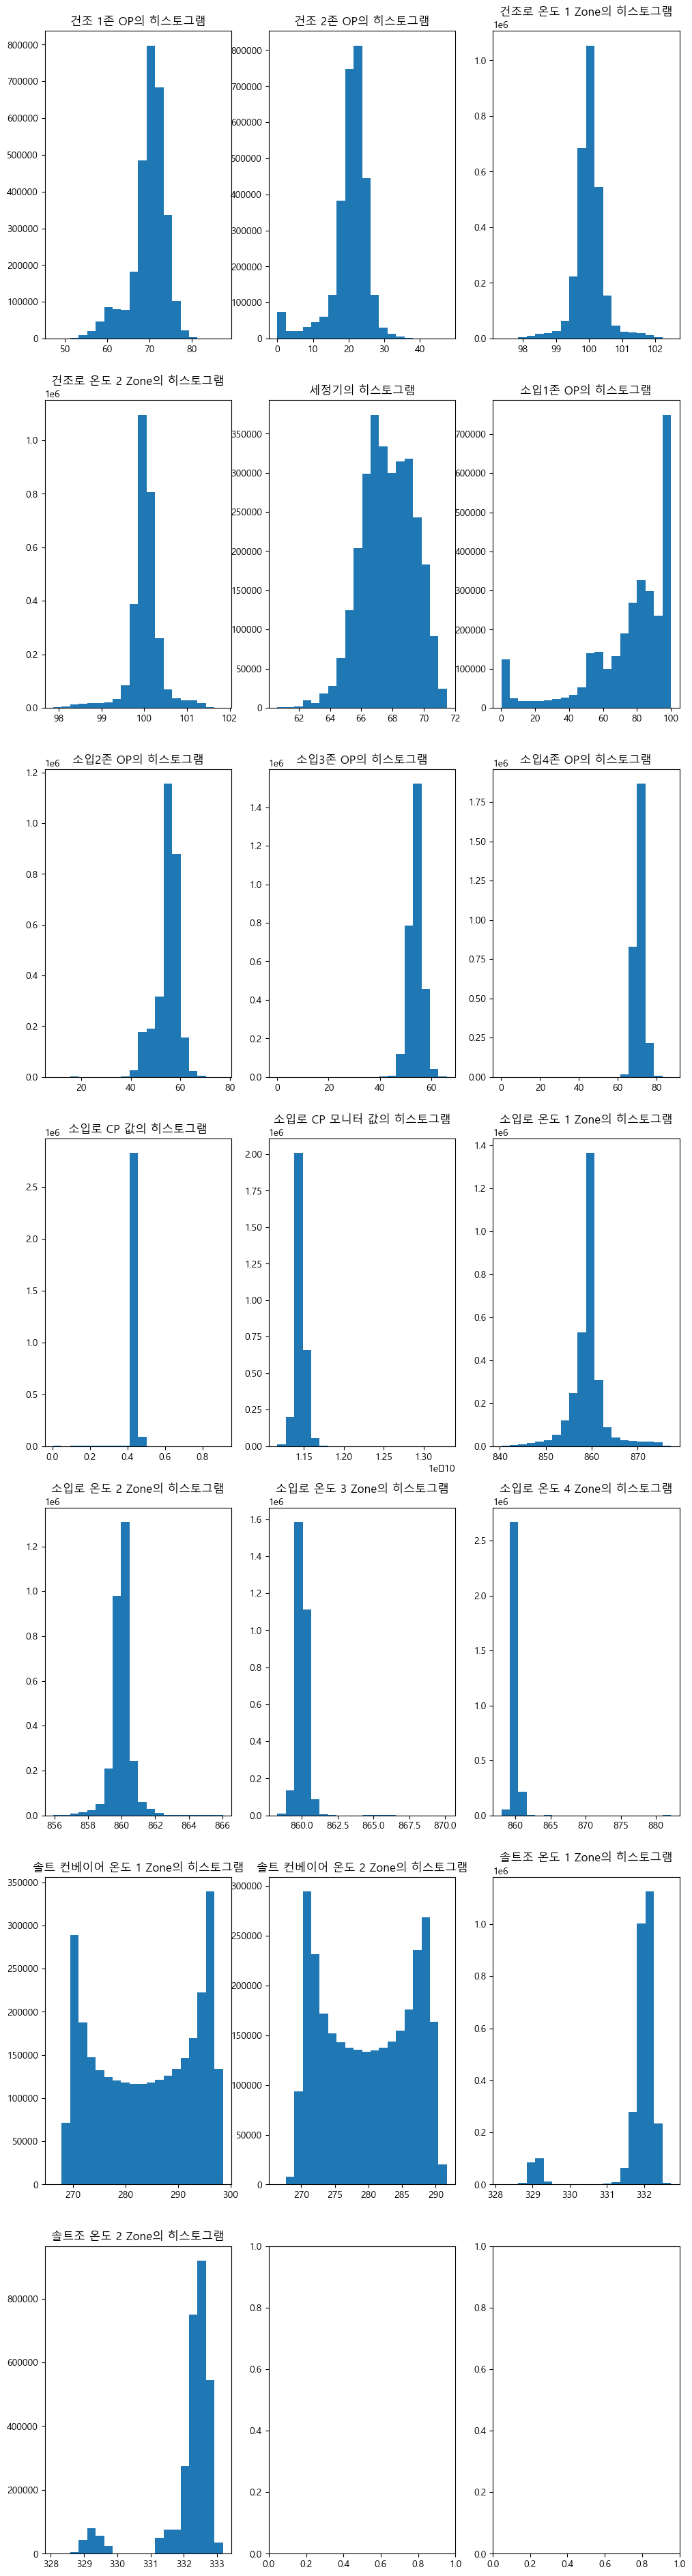

In [12]:
# 전체 데이터의 컬럼별 히스토그램

plt.rcParams["font.family"] = 'Malgun Gothic'

fig, axs = plt.subplots(figsize=(12,48), nrows=((df_dr.shape[1]-2)//3)+1, ncols=3)

for h in range(df_dr.shape[1]-2) : 
    axs[h // 3][h % 3].hist(df_dr.iloc[:,h+2], bins=20)
    axs[h // 3][h % 3].set_title(df_dr.columns[h+2]+"의 히스토그램")

plt.show()

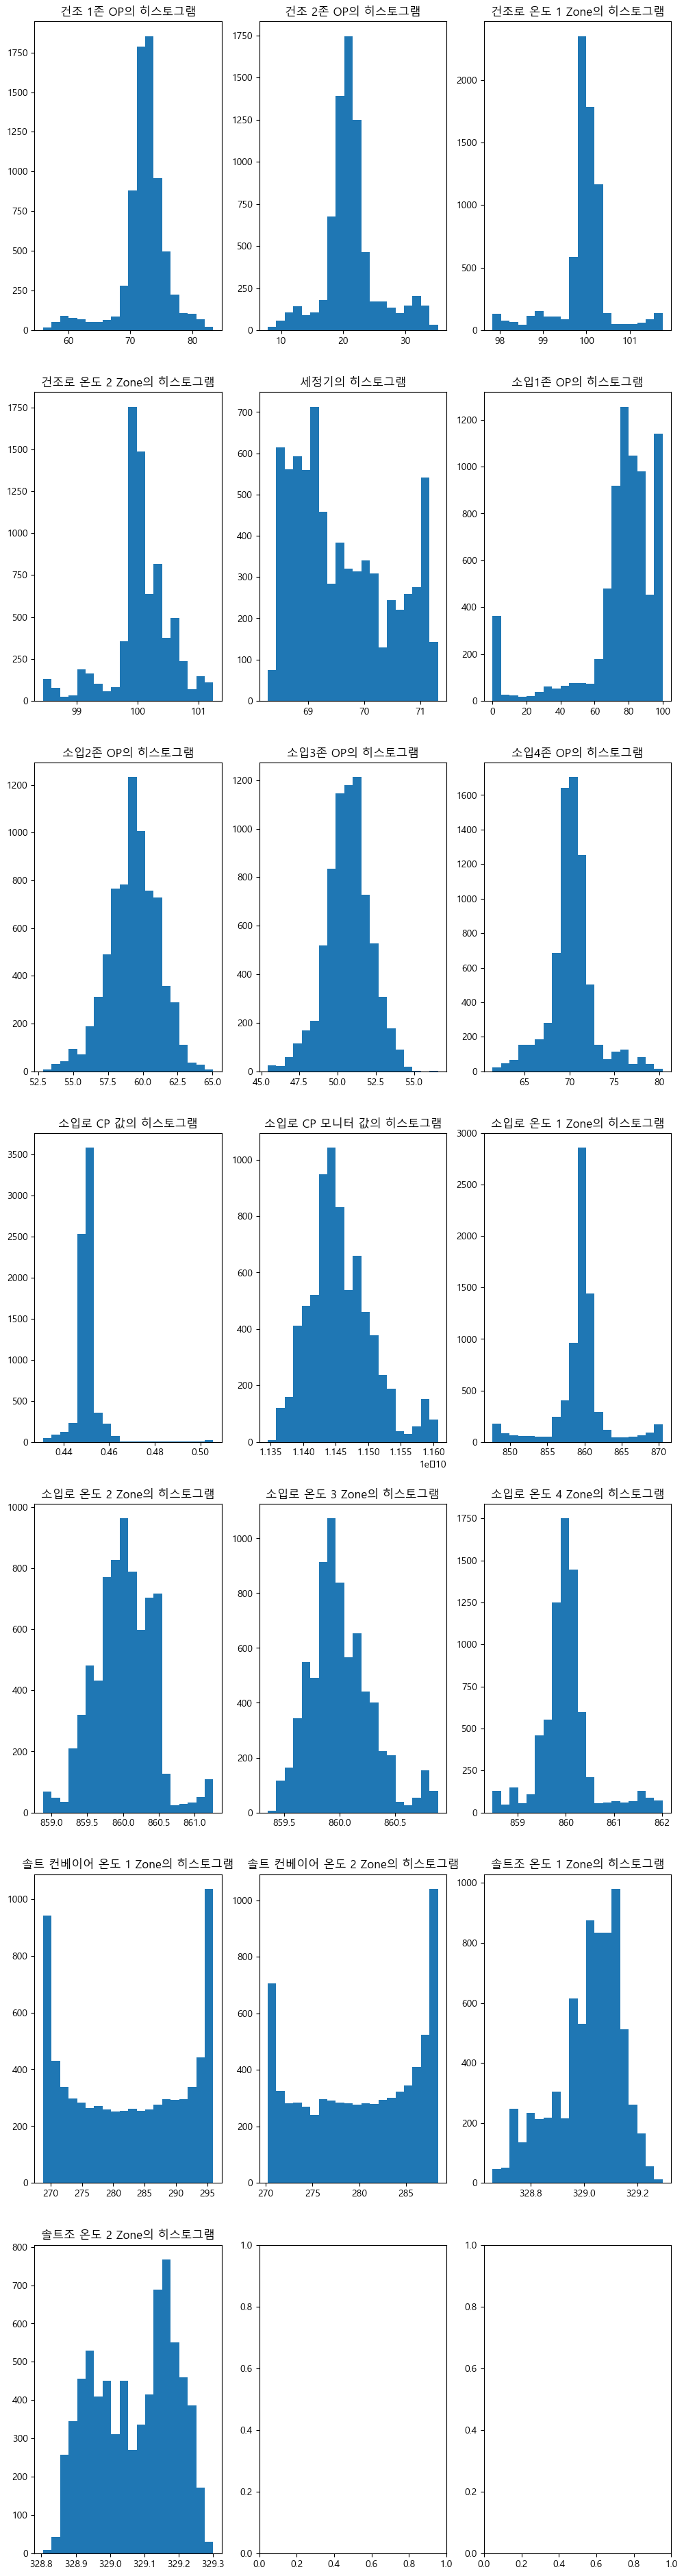

In [43]:
plt.rcParams["font.family"] = 'Malgun Gothic'

fig, axs = plt.subplots(figsize=(12,48), nrows=((df_dr.shape[1]-2)//3)+1, ncols=3)

for h in range(df_dr.shape[1]-2) : 
    axs[h // 3][h % 3].hist(df_dr[df["배정번호"]==102410].iloc[:,h+2], bins=20)
    axs[h // 3][h % 3].set_title(df_dr.columns[h+2]+"의 히스토그램")

plt.show()

데이터의 분포가 정규 분포를 따르지 않는 것처럼 보이며,  
  
평균을 사용하기 보다는 중앙값(혹은 최빈값)을 사용

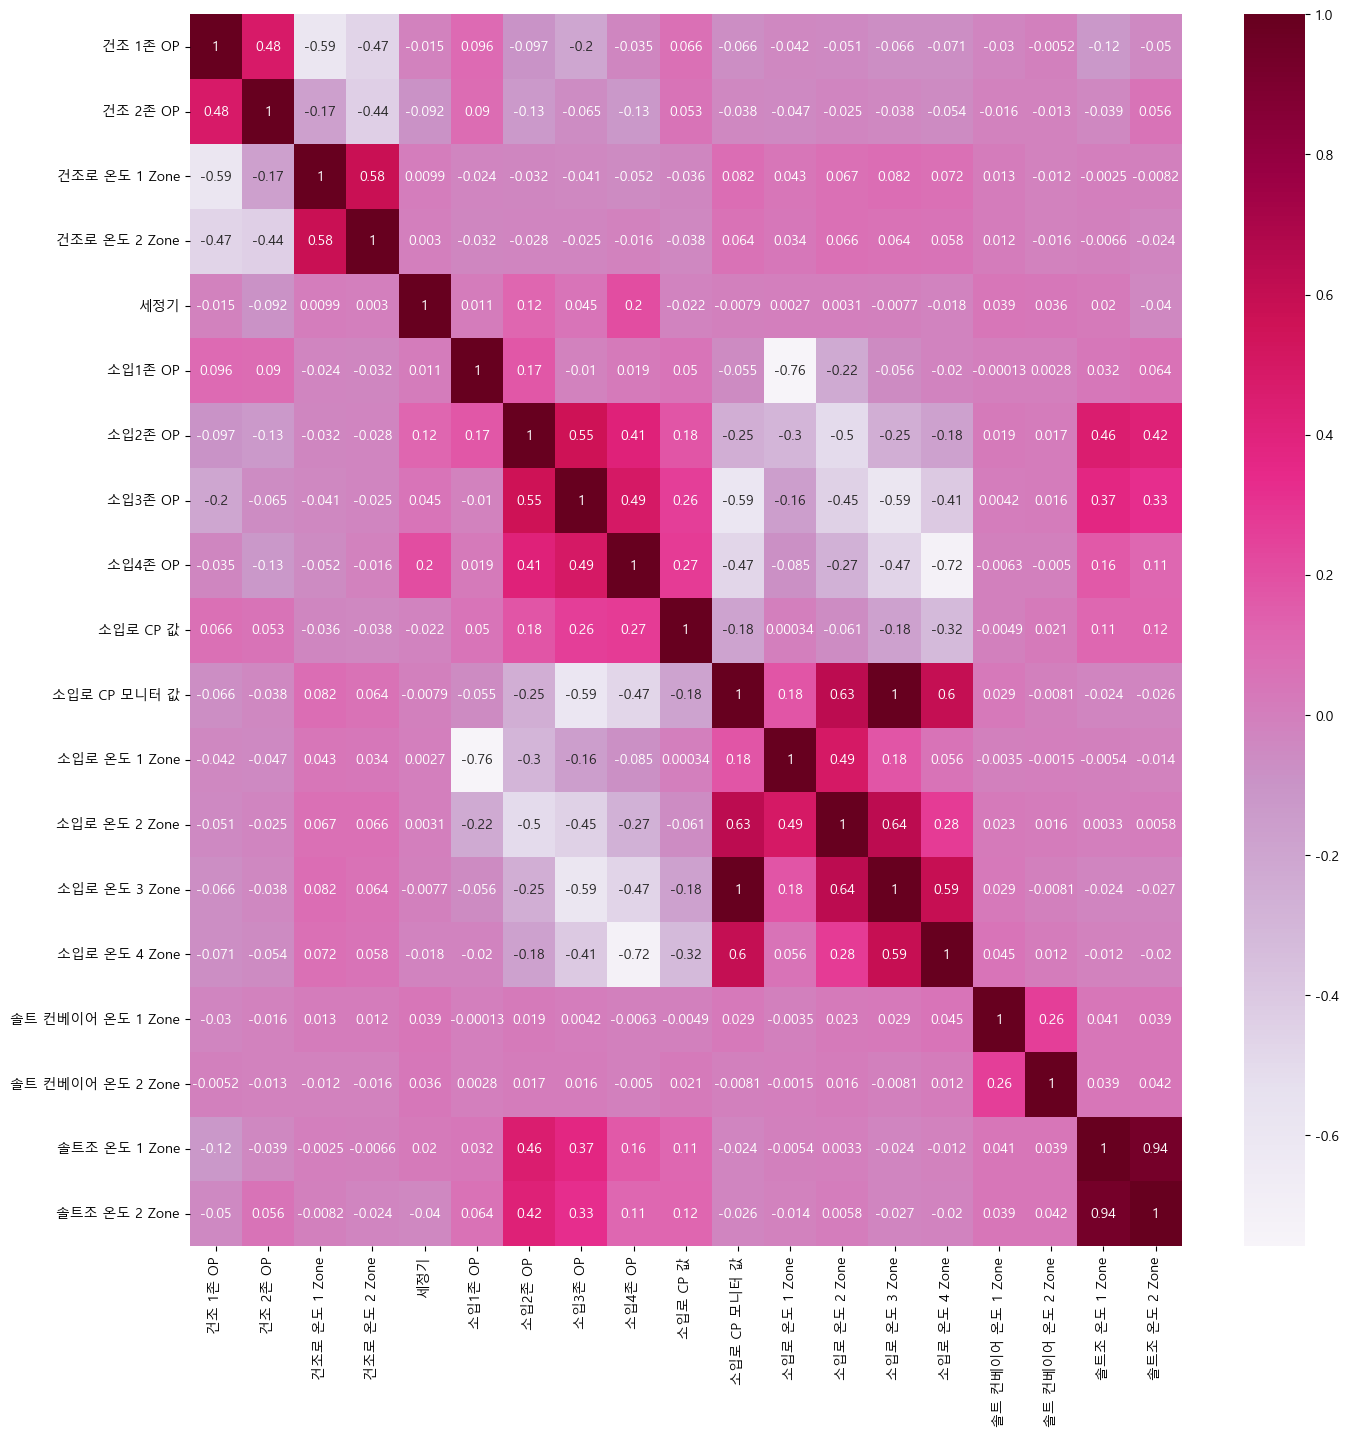

In [52]:
df_corr = df_dr.iloc[:,2:].corr("pearson")

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(16,16))

sns.heatmap(df_corr, cmap="PuRd", annot=True)
plt.show()

상관 계수의 절댓값이 0.3 이상인 컬럼만 추출

In [14]:
df_corr[(df_corr.abs() >= 0.3) & (df_corr.abs() != 1) & (df_corr.notnull())]

,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,소입4존 OP,소입로 CP 값,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
건조 1존 OP,NaN,0.484,-0.588,-0.468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
건조 2존 OP,0.484,NaN,NaN,-0.437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
건조로 온도 1 Zone,-0.588,NaN,NaN,0.578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
건조로 온도 2 Zone,-0.468,-0.437,0.578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
세정기,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
소입1존 OP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
소입2존 OP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555,0.410,NaN,NaN,NaN,-0.498,NaN,NaN,NaN,NaN,0.455,0.422
소입3존 OP,NaN,NaN,NaN,NaN,NaN,NaN,0.555,NaN,0.494,NaN,-0.595,NaN,-0.447,-0.592,-0.407,NaN,NaN,0.369,0.327
소입4존 OP,NaN,NaN,NaN,NaN,NaN,NaN,0.410,0.494,NaN,NaN,-0.474,NaN,NaN,-0.470,-0.718,NaN,NaN,NaN,NaN
소입로 CP 값,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.319,NaN,NaN,NaN,NaN


#### 차원 축소 : 차원이 증가하면서 발생하는 과적합과 차원의 저주를 방지

데이터 수집 시간과 배정 번호를 제외한 컬럼의 설명을 살펴보면,  
  
- 건조 1~2존 OP : 각 건조 온도 유지를 위한 출력 량(%)
- 건조로 온도 1~2 Zone : 각 건조로 Zone의 온도 값
- 세정기 : 세정기 온도 값
- 소입 1~4존 OP : 각 소입존 온도 유지를 위한 출력 량(%)
- 소입로 CP 값 : 침탄 가스의 침탄 능력의 양(%) >> 침탄되는 탄소의 양 >> 침탄된 탄소의 양 / 분사된 탄소 (% ?)
- 소입로 온도 1~4 Zone : 각 소입로 Zone의 온도 값
- 솔트 컨베이어 온도 1~2 Zone : 각 솔트 컨베이어 Zone의 온도 값
- 솔트조 온도 1~2 Zone : 각 솔트조 Zone의 온도 값

건조로, 소입로, 솔트조(염욕로) 전부 온도를 일정 수준 올려 유지해야하며,  
  
그에 따른 에너지 공급이 필요하다.  
  
그래서 각 노마다 'OP'라고 불리는 컬럼이 존재 >>  
  
온도 유지를 위해서는 에너지를 계속 공급해줘야 하며, 각 기기마다 최대 출력(%)이 정해진 것으로 예상됨.  
  
열처리에서 중요한 것은, 노 온도를 올리고 유지하기 위해 가해지는 에너지가 아니라,  
  
노 내부의 온도가 중요하기 때문에  
  
OP 컬럼은 전부 제외해도 무방하다고 가정(각 공정의 온도와 상관성이 높기도 함)

In [15]:
# 'OP'가 속해있는 컬럼 전부 제외

df_dr_cl = df_dr.drop(['건조 1존 OP', '건조 2존 OP','소입1존 OP', '소입2존 OP', '소입3존 OP', '소입4존 OP'],axis=1)

df_dr_cl.head()

,TAG_MIN,배정번호,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입로 CP 값,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
2,2022-01-03 11:22:09,102410,98.853,99.146,68.439,0.450,0.000,860.338,859.780,859.981,859.724,294.658,272.538,328.734,328.805
3,2022-01-03 11:22:11,102410,98.792,99.177,68.500,0.450,0.000,860.338,859.842,859.950,859.599,294.719,272.538,328.674,328.865
4,2022-01-03 11:22:12,102410,98.792,99.207,68.439,0.450,0.000,860.351,859.791,859.991,859.731,294.721,272.599,328.740,328.808
5,2022-01-03 11:22:13,102410,98.792,99.146,68.439,0.450,0.000,860.351,859.791,859.991,859.731,294.721,272.599,328.740,328.808
6,2022-01-03 11:22:14,102410,98.792,99.207,68.439,0.451,0.000,860.351,859.854,859.991,859.731,294.781,272.599,328.740,328.869


'소입로 CP 모니터 값'의 경우,  
  
'소입로 CP 값' 컬럼과의 연관성을 알기 어렵고,

숫자의 크기가 0에 근접할 만큼 작아(최댓값이 1.329290e-10)

컬럼을 제외해도 무방하다고 가정

In [16]:
# 소입로 CP 모니터 값 제외

df_dr_cl.drop("소입로 CP 모니터 값", axis=1, inplace=True)

df_dr_cl.columns

Index(['TAG_MIN', '배정번호', '건조로 온도 1 Zone', '건조로 온도 2 Zone', '세정기', '소입로 CP 값',
       '소입로 온도 1 Zone', '소입로 온도 2 Zone', '소입로 온도 3 Zone', '소입로 온도 4 Zone',
       '솔트 컨베이어 온도 1 Zone', '솔트 컨베이어 온도 2 Zone', '솔트조 온도 1 Zone',
       '솔트조 온도 2 Zone'],
      dtype='object')

In [17]:
# plt.rcParams["font.family"] = 'Malgun Gothic'

# fig, axs = plt.subplots(figsize=(12,24), nrows=((df_dr_cl.shape[1]-2)//3), ncols=3)

# for h in range(df_dr_cl.shape[1]-2) : 
#     axs[h // 3][h % 3].boxplot(df_dr_cl.iloc[:,h+2])
#     axs[h // 3][h % 3].set_title(df_dr_cl.columns[h+2]+"의 상자수염그림")

# plt.show()

만약 통계적으로 평균에 차이가 없다면,  
  
같은 공정에서 Zone만 다른 변수를 평균 또는 중앙값으로 합쳐서 표현할 수 있을 것이라고 판단  

Q-Q plot으로 정규성을 파악한 후  
  
t-test와 ANOVA를 병행해 통계적으로 평균 차이 검정

#### Q-Q Plot

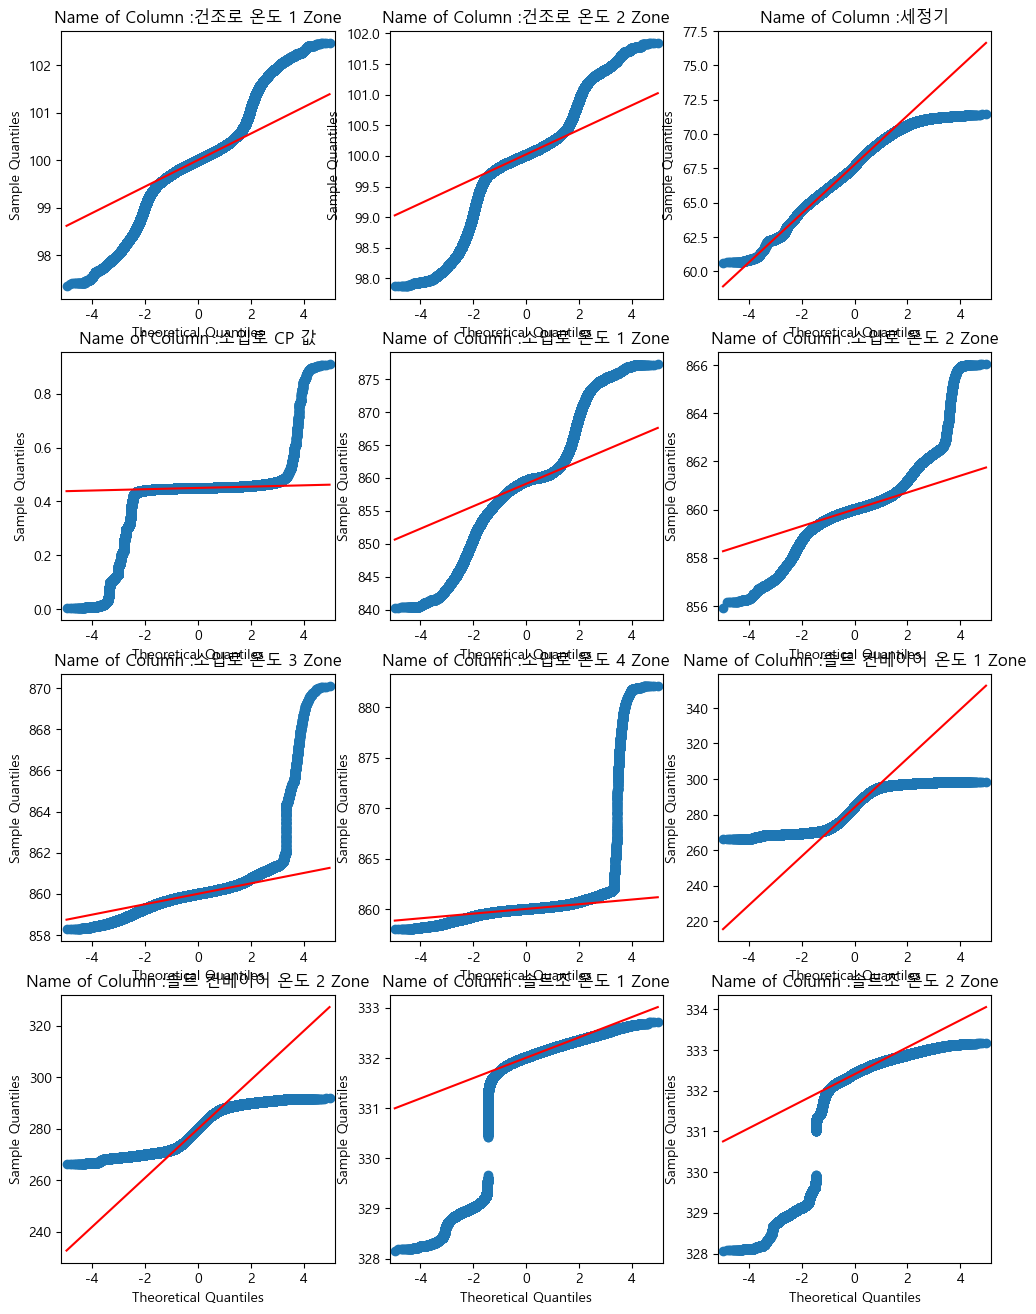

In [51]:
len_df_dc = df_dr_cl.shape[1]-2

plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

fig, axs = plt.subplots(figsize=(12,16), nrows=(len_df_dc//3), ncols=3)

for i in range(len_df_dc) : 
    api.qqplot(df_dr_cl.iloc[:,i+2], stats.norm, line='q', ax=axs[(i//3),(i % 3)])
    axs[(i//3),(i % 3)].set_title("Name of Column :"+ df_dr_cl.columns[i+2])

plt.show()

In [24]:
# 콜모고로프-스미르노프 검정

for i in range(len_df_dc) : 
    test_stat, p_val = stats.kstest(df_dr_cl.iloc[:,i+2],'norm')

    if p_val < 0.05 : 
        print("유의 수준 5%에서 "+df_dr_cl.columns[i+2]+"는 정규성을 가진다고 말할 수 없습니다.")
    else : 
        print("유의 수준 5%에서 "+df_dr_cl.columns[i+2]+"는 정규성을 가진다고 말할 수 있습니다.")

유의 수준 5%에서 건조로 온도 1 Zone는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 건조로 온도 2 Zone는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 세정기는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 소입로 CP 값는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 소입로 온도 1 Zone는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 소입로 온도 2 Zone는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 소입로 온도 3 Zone는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 소입로 온도 4 Zone는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 솔트 컨베이어 온도 1 Zone는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 솔트 컨베이어 온도 2 Zone는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 솔트조 온도 1 Zone는 정규성을 가진다고 말할 수 없습니다.
유의 수준 5%에서 솔트조 온도 2 Zone는 정규성을 가진다고 말할 수 없습니다.


독립 변수가 정규 분포를 따르지 않으므로,  
  
비모수 검정으로 집

In [35]:
# # '건조로 온도'를 맨 휘트니 검정

# man_dry = stats.mannwhitneyu(df_dr_cl["건조로 온도 1 Zone"], df_dr_cl["건조로 온도 2 Zone"])

# print(man_dry)

# if man_dry[1] < 0.05 : 
#     print("두 컬럼 간에 차이가 있을 수도 있다")
# else : 
#     print("두 컬럼 간에 차이가 없다")

In [37]:
# # '솔트 컨베이어 온도'를 맨 휘트니 검정

# man_con = stats.mannwhitneyu(df_dr_cl["솔트 컨베이어 온도 1 Zone"], df_dr_cl["솔트 컨베이어 온도 2 Zone"])

# print(man_con)

# if man_con[1] < 0.05 : 
#     # print("두 컬럼 간에 차이가 있을 수도 있다")
# else : 
#     # print("두 컬럼 간에 차이가 없다")

In [38]:
# # '솔트조 온도'를 맨 휘트니 검정

# man_salt = stats.mannwhitneyu(df_dr_cl["솔트조 온도 1 Zone"], df_dr_cl["솔트조 온도 2 Zone"])

# print(man_salt)

# if man_salt[1] < 0.05 : 
#     print("두 컬럼 간에 차이가 있을 수도 있다")
# else : 
#     print("두 컬럼 간에 차이가 없다")

#### 불량률과 변수 간의 상관 관계

In [39]:
df_qual = pd.read_excel(dir_data+"/quality.xlsx")

df_qual.info()
df_qual.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   배정번호    136 non-null    int64         
 1   작업일     136 non-null    datetime64[ns]
 2   공정명     136 non-null    object        
 3   설비명     136 non-null    object        
 4   양품수량    136 non-null    int64         
 5   불량수량    136 non-null    int64         
 6   총수량     136 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 7.6+ KB


,배정번호,작업일,공정명,설비명,양품수량,불량수량,총수량
0,102410,2022-01-03,열처리,열처리 염욕_1,15160,3,15163
1,102585,2022-01-03,열처리,열처리 염욕_1,29892,10,29902
2,102930,2022-01-04,열처리,열처리 염욕_1,59616,30,59646
3,103142,2022-01-05,열처리,열처리 염욕_1,74730,13,74743
4,103675,2022-01-06,열처리,열처리 염욕_1,14979,2,14981


In [40]:
# 배정 번호를 기준으로 불량률을 계산할 수 있음(불량수량 / 총수량)

# 불량률 컬럼을 추가

df_qual["불량률"] = df_qual["불량수량"] / df_qual["총수량"]

df_qual.head()

,배정번호,작업일,공정명,설비명,양품수량,불량수량,총수량,불량률
0,102410,2022-01-03,열처리,열처리 염욕_1,15160,3,15163,0.000
1,102585,2022-01-03,열처리,열처리 염욕_1,29892,10,29902,0.000
2,102930,2022-01-04,열처리,열처리 염욕_1,59616,30,59646,0.001
3,103142,2022-01-05,열처리,열처리 염욕_1,74730,13,74743,0.000
4,103675,2022-01-06,열처리,열처리 염욕_1,14979,2,14981,0.000


기존 데이터와 품질 데이터를 join

In [42]:
df_gb2 = df_dr_cl.groupby("배정번호")[df_dr_cl.columns[2:]].median()

df_gb2

,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입로 CP 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
배정번호,,,,,,,,,,,,
102410,99.980,100.038,69.385,0.450,859.686,860.016,859.970,859.993,282.782,280.625,329.039,329.089
102585,99.983,100.020,69.470,0.450,859.542,860.047,859.986,860.034,283.161,279.883,328.996,328.936
102930,99.999,100.010,69.564,0.450,859.797,859.986,859.998,860.003,283.838,279.356,329.147,329.180
103142,100.018,100.017,69.635,0.450,859.924,859.968,859.999,859.991,283.279,279.126,329.091,329.100
103675,99.943,100.054,69.274,0.450,859.772,859.963,860.040,859.958,285.159,276.536,329.012,329.108
...,...,...,...,...,...,...,...,...,...,...,...,...
147292,100.009,100.009,69.472,0.450,859.519,859.971,859.985,859.984,285.344,280.857,332.189,332.248
147546,99.999,99.991,70.228,0.450,859.874,859.990,859.998,860.004,284.608,280.100,332.195,332.257
147982,100.016,99.989,70.002,0.450,859.631,859.986,860.003,860.006,284.868,280.177,332.222,332.162


In [44]:
df_gb2.reset_index(level=0, drop=False, inplace=True)

df_gb2.head()

,배정번호,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입로 CP 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
0,102410,99.980,100.038,69.385,0.450,859.686,860.016,859.970,859.993,282.782,280.625,329.039,329.089
1,102585,99.983,100.020,69.470,0.450,859.542,860.047,859.986,860.034,283.161,279.883,328.996,328.936
2,102930,99.999,100.010,69.564,0.450,859.797,859.986,859.998,860.003,283.838,279.356,329.147,329.180
3,103142,100.018,100.017,69.635,0.450,859.924,859.968,859.999,859.991,283.279,279.126,329.091,329.100
4,103675,99.943,100.054,69.274,0.450,859.772,859.963,860.040,859.958,285.159,276.536,329.012,329.108


In [295]:
df_join = pd.merge(left=df_gb2, right=df_qual[["배정번호", "불량률"]], on="배정번호")

df_join.head()

,배정번호,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입로 CP 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone,불량률
0,102410,99.980,100.038,69.385,0.450,859.686,860.016,859.970,859.993,282.782,280.625,329.039,329.089,0.000
1,102585,99.983,100.020,69.470,0.450,859.542,860.047,859.986,860.034,283.161,279.883,328.996,328.936,0.000
2,102930,99.999,100.010,69.564,0.450,859.797,859.986,859.998,860.003,283.838,279.356,329.147,329.180,0.001
3,103142,100.018,100.017,69.635,0.450,859.924,859.968,859.999,859.991,283.279,279.126,329.091,329.100,0.000
4,103675,99.943,100.054,69.274,0.450,859.772,859.963,860.040,859.958,285.159,276.536,329.012,329.108,0.000


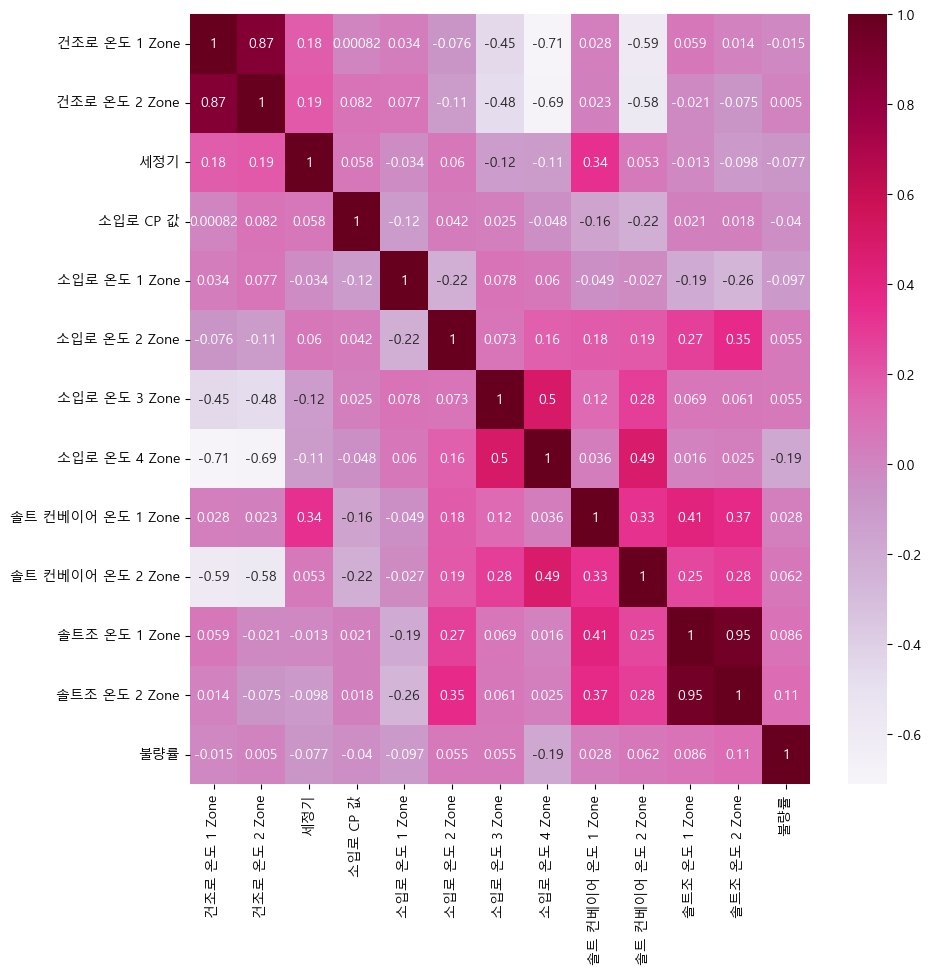

In [296]:
plt.figure(figsize=(10,10))
plt.rcParams['axes.unicode_minus'] = False

df_join_corr = df_join.drop("배정번호",axis=1).corr("pearson")

sns.heatmap(df_join_corr, cmap="PuRd", annot=True)
plt.show()

각 독립 변수와 종속 변수 간의 상관성은 크지 않은 것으로 파악됨  
  
→ 소입로 온도 4 Zone과 솔트조 온도 2 Zone이 그나마 상관 관계가 존재(하지만 그것조차 유의미 X)
  
→ 같은 공정 다른 Zone에서 상관성을 보이므로, 다중공선성 방지를 위해 파생변수를 만들거나 제거해 차원을 축소할 필요가 있어 보임

불량률과의 상관성이 낮은 변수 쪽을 제거

In [297]:
df_join_dr = df_join.drop(["건조로 온도 2 Zone", "소입로 온도 2 Zone", "소입로 온도 3 Zone", "솔트 컨베이어 온도 1 Zone", "솔트조 온도 1 Zone"],
                          axis=1)

df_join_dr.head()

,배정번호,건조로 온도 1 Zone,세정기,소입로 CP 값,소입로 온도 1 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 2 Zone,불량률
0,102410,99.980,69.385,0.450,859.686,859.993,280.625,329.089,0.000
1,102585,99.983,69.470,0.450,859.542,860.034,279.883,328.936,0.000
2,102930,99.999,69.564,0.450,859.797,860.003,279.356,329.180,0.001
3,103142,100.018,69.635,0.450,859.924,859.991,279.126,329.100,0.000
4,103675,99.943,69.274,0.450,859.772,859.958,276.536,329.108,0.000


열처리를 통해 조직을 변태하는 것은  
  
특정 온도가 아니라 온도의 범위 내에서 변태를 하기에,  
  
1~2℃의 온도차는 재료의 성질에 크게 영향을 미치지 않음  
  
→ 소입로 온도 Zone을 평균을 내어 하나의 파생 변수로 생성

In [298]:
df_join_dr["소입로 온도 1-4 Zone"] = (df_join_dr["소입로 온도 1 Zone"] + df_join_dr["소입로 온도 4 Zone"]) / 2

df_join_dr.head()

,배정번호,건조로 온도 1 Zone,세정기,소입로 CP 값,소입로 온도 1 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 2 Zone,불량률,소입로 온도 1-4 Zone
0,102410,99.980,69.385,0.450,859.686,859.993,280.625,329.089,0.000,859.839
1,102585,99.983,69.470,0.450,859.542,860.034,279.883,328.936,0.000,859.788
2,102930,99.999,69.564,0.450,859.797,860.003,279.356,329.180,0.001,859.900
3,103142,100.018,69.635,0.450,859.924,859.991,279.126,329.100,0.000,859.957
4,103675,99.943,69.274,0.450,859.772,859.958,276.536,329.108,0.000,859.865


In [299]:
df_join_dr.drop(["소입로 온도 1 Zone", "소입로 온도 4 Zone"], axis=1, inplace=True)

df_join_dr = df_join_dr[['배정번호','건조로 온도 1 Zone', '세정기', '소입로 CP 값', 
                         '소입로 온도 1-4 Zone', '솔트 컨베이어 온도 2 Zone', '솔트조 온도 2 Zone', '불량률']]

df_join_dr

,배정번호,건조로 온도 1 Zone,세정기,소입로 CP 값,소입로 온도 1-4 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 2 Zone,불량률
0,102410,99.980,69.385,0.450,859.839,280.625,329.089,0.000
1,102585,99.983,69.470,0.450,859.788,279.883,328.936,0.000
2,102930,99.999,69.564,0.450,859.900,279.356,329.180,0.001
3,103142,100.018,69.635,0.450,859.957,279.126,329.100,0.000
4,103675,99.943,69.274,0.450,859.865,276.536,329.108,0.000
...,...,...,...,...,...,...,...,...
131,147292,100.009,69.472,0.450,859.752,280.857,332.248,0.000
132,147546,99.999,70.228,0.450,859.939,280.100,332.257,0.000
133,147982,100.016,70.002,0.450,859.818,280.177,332.162,0.000
134,147996,99.980,69.525,0.450,859.812,280.837,332.178,0.000


In [96]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot_pacf(df_join_dr["불량률"])

# plt.show()

# # 다음 공정은 자기상관성이 있음?

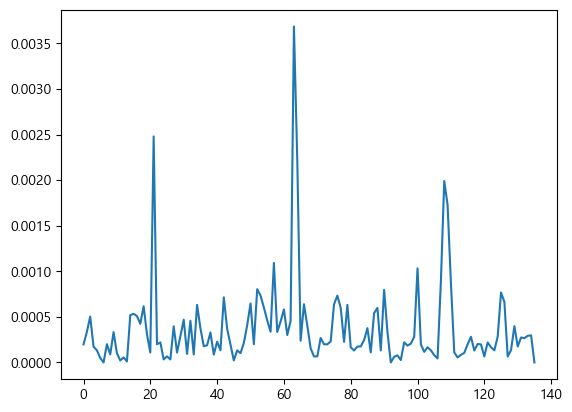

In [72]:
# 불량률 추이 파악

plt.plot(df_join_dr.index.to_list(), df_join_dr["불량률"])

plt.show()

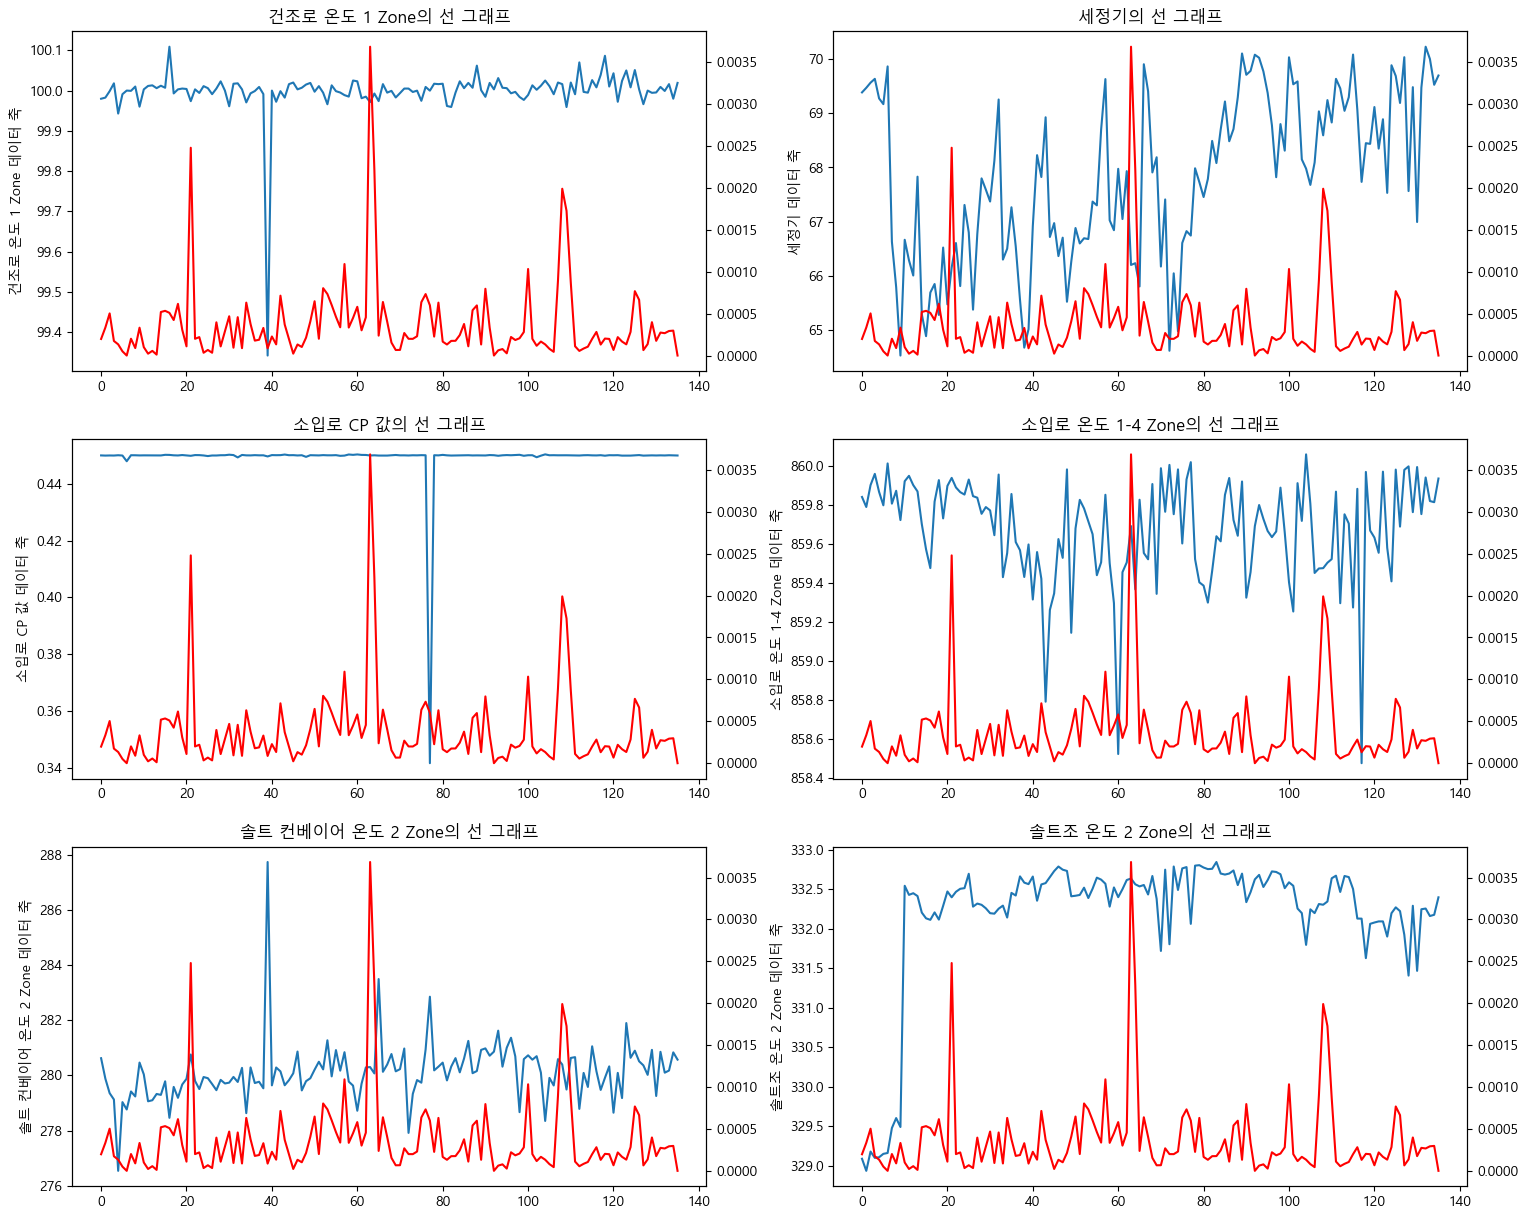

In [301]:
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.family"] = 'Malgun Gothic'

fig, axs = plt.subplots(figsize=(18,15), nrows=3, ncols=2)

for i in range(6) : 
    ax = axs[i // 2][i % 2]
    ax.plot(df_join_dr.index, df_join_dr.iloc[:,i+1])
    # ax.legend()

    ax2 = ax.twinx()
    ax2.plot(df_join_dr.index, df_join_dr["불량률"], color="red")
    # ax2.legend()

    ax.set_title(df_join_dr.columns[i+1]+"의 선 그래프")

    ax.set_ylabel(df_join_dr.columns[i + 1] + " 데이터 축")
    # ax2.set_ylabel("공통 선 그래프 축")
    
    # 범례 추가

plt.show()

독립 변수의 추이와 불량률 간의 추이는 큰 관계가 없는 것으로 보임

#### 불량률 기준 정하기

제품 불량의 기준을 정규 분포에서 ± 3 sigma로 가정했을 때,  
  
불량의 기준은 약 0.0027

In [302]:
print("불량이 아닌 배정 번호의 개수 : "+str(df_join_dr[df_join_dr["불량률"] < 0.0027].shape[0]))
print("불량인 배정 번호의 개수 : "+str(df_join_dr[df_join_dr["불량률"] >= 0.0027].shape[0]))

불량이 아닌 배정 번호의 개수 : 135
불량인 배정 번호의 개수 : 1


제품 불량의 기준을 정규 분포에서 ± 3.5 sigma로 가정했을 때,  
  
불량의 기준은 약 0.0004

In [303]:
print("불량이 아닌 배정 번호의 개수 : "+str(df_join_dr[df_join_dr["불량률"] < 0.0004].shape[0]))
print("불량인 배정 번호의 개수 : "+str(df_join_dr[df_join_dr["불량률"] >= 0.0004].shape[0]))

불량이 아닌 배정 번호의 개수 : 97
불량인 배정 번호의 개수 : 39


In [304]:
df_3sig = df_join_dr["불량률"].map(lambda x : 1 if x < 0.0027 else 0)

df_3sig[df_3sig == 0]

63    0
Name: 불량률, dtype: int64

In [305]:
df_3d5_sig = df_join_dr["불량률"].map(lambda x : 1 if x < 0.0004 else 0)

df_3d5_sig[df_3d5_sig == 0]

2      0
14     0
15     0
16     0
17     0
18     0
21     0
30     0
32     0
34     0
42     0
49     0
50     0
52     0
53     0
54     0
55     0
57     0
59     0
60     0
62     0
63     0
64     0
66     0
67     0
75     0
76     0
77     0
79     0
87     0
88     0
90     0
100    0
107    0
108    0
109    0
110    0
125    0
126    0
Name: 불량률, dtype: int64

In [306]:
# 불량 기준이 0.001일 때
print("불량이 아닌 배정 번호의 개수 : "+str(df_join_dr[df_join_dr["불량률"] < 0.001].shape[0]))
print("불량인 배정 번호의 개수 : "+str(df_join_dr[df_join_dr["불량률"] >= 0.001].shape[0]))

df_tz = df_join_dr["불량률"].map(lambda x : 1 if x < 0.001 else 0)

df_tz[df_tz == 0]

불량이 아닌 배정 번호의 개수 : 129
불량인 배정 번호의 개수 : 7


21     0
57     0
63     0
64     0
100    0
108    0
109    0
Name: 불량률, dtype: int64

## 모델 학습과 예측

#### 배정 번호별로 중앙값으로 통일된 변수의 정규성 확인

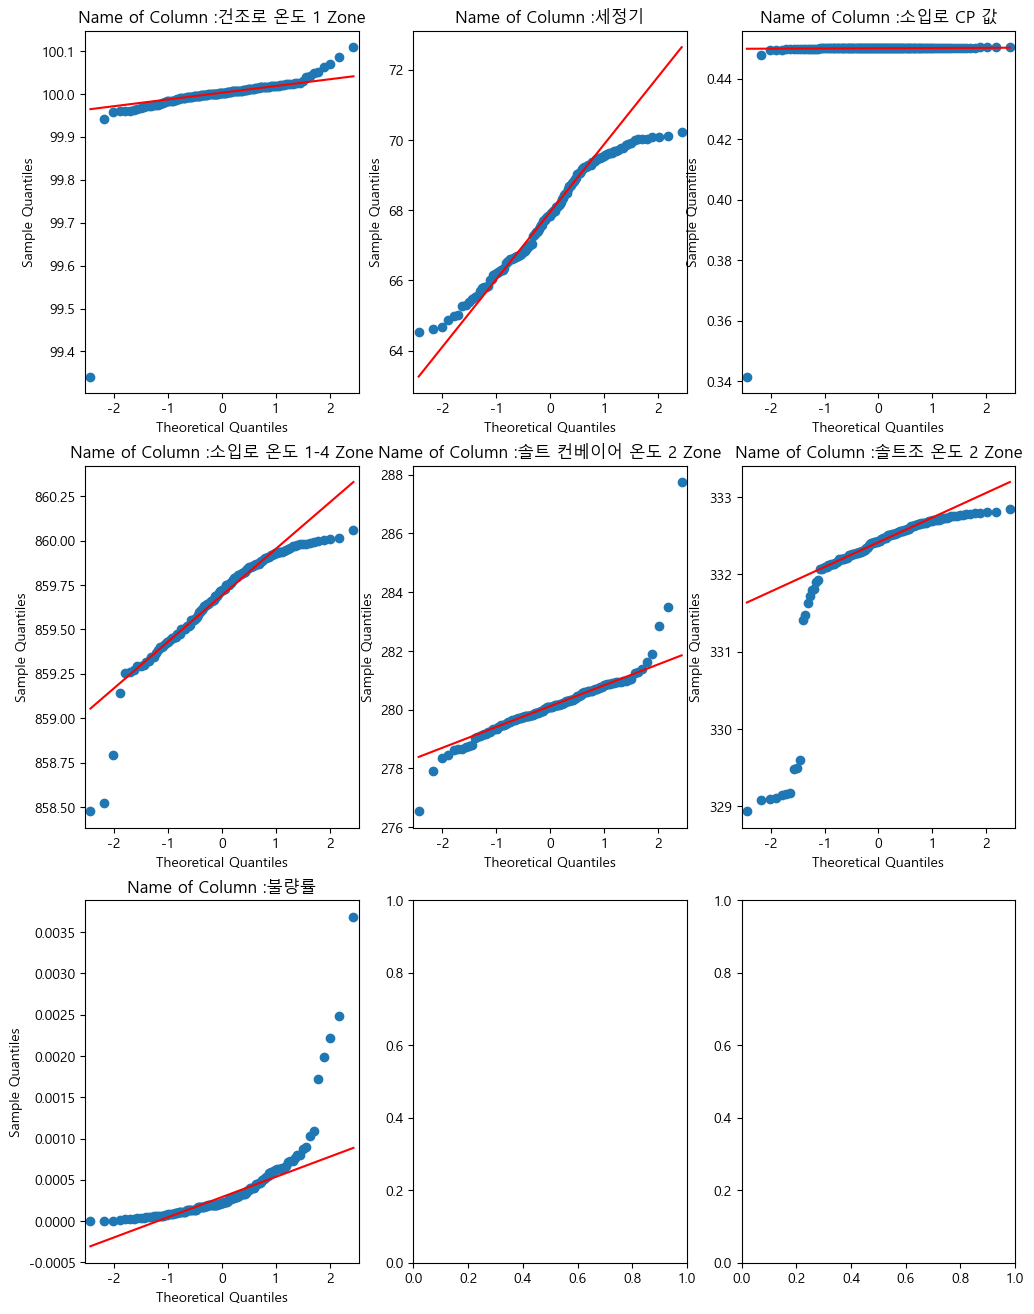

In [307]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

fig, axs = plt.subplots(figsize=(12,16), nrows=3, ncols=3)

for i in range(7) : 
    ax = axs[(i//3),(i % 3)]
    api.qqplot(df_join_dr.iloc[:,i+1], stats.norm, line='q', ax=ax)
    ax.set_title("Name of Column :"+ df_join_dr.columns[i+1])

plt.show()

#### train-validation data 분리

In [308]:
X = df_join_dr.drop(["배정번호", "불량률"],axis=1)
y = df_tz

print(X.shape)
print(y.shape)

(136, 6)
(136,)


In [309]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=randomSt)

print("독립 변수 훈련 데이터 : ",X_train.shape)
print("종속 변수 훈련 데이터 : ",y_train.shape)
print("독립 변수 검증 데이터 : ",X_val.shape)
print("종속 변수 검증 데이터 : ",y_val.shape)

독립 변수 훈련 데이터 :  (95, 6)
종속 변수 훈련 데이터 :  (95,)
독립 변수 검증 데이터 :  (41, 6)
종속 변수 검증 데이터 :  (41,)


#### minmaxscaling

In [121]:
def scaling(dataframe) : 

    sc = MinMaxScaler()
    
    sc.fit(dataframe)

    df_sc = sc.transform(dataframe)

    df_sc = pd.DataFrame(df_sc, columns=dataframe.columns)

    return sc, df_sc

In [310]:
scaler1, X_sc = scaling(X_train)

print(X_sc)

    건조로 온도 1 Zone   세정기  소입로 CP 값  소입로 온도 1-4 Zone  솔트 컨베이어 온도 2 Zone  \
0           0.883 0.907     0.647            0.953              0.270   
1           0.814 0.377     0.709            0.805              0.342   
2           0.875 0.878     0.732            0.493              0.270   
3           0.838 0.909     0.654            0.541              0.312   
4           0.862 0.974     0.739            0.788              0.300   
..            ...   ...       ...              ...                ...   
90          0.853 0.266     0.726            0.830              0.144   
91          0.874 0.635     0.585            0.806              0.222   
92          0.849 0.232     0.708            0.873              0.170   
93          0.939 0.836     0.689            0.755              0.228   
94          0.850 0.288     0.693            0.989              0.235   

    솔트조 온도 2 Zone  
0           0.890  
1           0.888  
2           0.930  
3           0.874  
4           0.951  
.. 

In [311]:
# X_val transform

X_val_sc = scaler1.transform(X_val)

X_val_sc

array([[ 8.77540386e-01,  1.74248807e-01,  1.89458689e-01,
         9.84469953e-01,  1.90970104e-01,  9.80302213e-01],
       [ 8.35591454e-01,  6.41972058e-01,  8.16714150e-01,
         5.54017556e-01,  2.27272727e-01,  8.85051268e-01],
       [ 8.46404377e-01,  1.48623982e-01,  6.47673314e-01,
         8.91964889e-01,  1.80394550e-01,  8.58337831e-01],
       [ 8.72980719e-01,  3.08375456e-01,  6.80911681e-01,
         9.62187711e-01,  1.16661582e-01,  8.98542903e-01],
       [ 8.38327254e-01,  5.97058411e-01,  8.25261159e-01,
         6.62727887e-01,  2.41712426e-01,  9.49271452e-01],
       [ 8.71026576e-01,  6.85446504e-01,  7.42640076e-01,
         7.73126266e-01,  2.45576571e-01,  7.99514301e-01],
       [ 8.31552892e-01,  8.52060517e-01,  6.73314340e-01,
         8.89095206e-01,  2.75676225e-01, -2.96815974e-03],
       [ 8.89265242e-01,  7.65076523e-01,  6.04938272e-01,
         9.76704929e-01,  1.28635347e-01,  8.07879115e-01],
       [ 8.98384575e-01,  9.64142797e-01,  5.546

#### oversampling

In [312]:
def oversample(X, y, knn=3, random_state=None) :
    smt = SMOTE(random_state=random_state, k_neighbors=knn)
    smt.fit(X,y)
    X_O, y_O = smt.fit_resample(X, y)

    return smt, X_O, y_O

In [336]:
# smote.fit(X_sc, y_train)
smote, X_train_over, y_train_over = oversample(X_sc, y_train, random_state=randomSt)

print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", X_sc.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts() )

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (95, 6) (95,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (180, 6) (180,)
SMOTE 적용 후 값의 분포 :
 불량률
1    90
0    90
Name: count, dtype: int64


### XGB

In [318]:
def make_xgb(X, y, random_state=None) : 
    model_xgb = XGBClassifier(learning_rate = 0.005, max_depth=5, randomstate=random_state, eval_metric=f1_score)
    model_xgb.fit(X,y)

    return model_xgb

In [341]:
# xgb = XGBClassifier(learning_rate = 0.005, max_depth=5, randomstate=randomSt)

# xgb.fit(X_train_over, y_train_over)

xgb = make_xgb(X_train_over, y_train_over, random_state=randomSt)

In [342]:
y_pred = xgb.predict(X_val_sc)

In [343]:
confusion_matrix(y_val, y_pred)

array([[ 1,  1],
       [ 5, 34]], dtype=int64)

In [344]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.50      0.25         2
           1       0.97      0.87      0.92        39

    accuracy                           0.85        41
   macro avg       0.57      0.69      0.58        41
weighted avg       0.93      0.85      0.89        41



In [345]:
y_pred_train = xgb.predict(X_train_over)

print(classification_report(y_train_over, y_pred_train))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        90
           1       0.97      0.96      0.96        90

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180



#### RFE_xgb

In [217]:
xgb_rfe = XGBClassifier(learning_rate = 0.005, max_depth=5, randomstate=randomSt, eval_metric=f1_score)

rfe = RFE(xgb_rfe, n_features_to_select=4, step=1)
model = rfe.fit(X_train_over,y_train_over)
# 선택될 변수
model.support_

# 변수 중요도(숫자 높을수록 불필요하다)
model.ranking_

array([1, 1, 1, 2, 3, 1])

In [218]:
y_pred_rfe = rfe.predict(X_val_sc)

print(confusion_matrix(y_val, y_pred_rfe))

print(classification_report(y_val, y_pred_rfe))

[[ 1  1]
 [ 5 34]]
              precision    recall  f1-score   support

           0       0.17      0.50      0.25         2
           1       0.97      0.87      0.92        39

    accuracy                           0.85        41
   macro avg       0.57      0.69      0.58        41
weighted avg       0.93      0.85      0.89        41



### SVM

In [346]:
def make_svm(X, y, random_state=None) : 
    model_svc = SVC(C=1, kernel="sigmoid", gamma="scale", random_state=random_state)

    model_svc.fit(X, y)

    return model_svc

In [347]:
# svc = SVC(C=1, kernel="sigmoid", gamma="scale", random_state=randomSt)

# svc.fit(X_train_over, y_train_over)

svc = make_svm(X_train_over, y_train_over, random_state=randomSt)

In [348]:
y_pred_svc = svc.predict(X_val_sc)

print(confusion_matrix(y_val, y_pred_svc))

print(classification_report(y_val, y_pred_svc))

[[ 2  0]
 [18 21]]
              precision    recall  f1-score   support

           0       0.10      1.00      0.18         2
           1       1.00      0.54      0.70        39

    accuracy                           0.56        41
   macro avg       0.55      0.77      0.44        41
weighted avg       0.96      0.56      0.67        41



In [349]:
y_pred_svc_t = svc.predict(X_train_over)

print(confusion_matrix(y_train_over, y_pred_svc_t))

print(classification_report(y_train_over, y_pred_svc_t))

[[61 29]
 [45 45]]
              precision    recall  f1-score   support

           0       0.58      0.68      0.62        90
           1       0.61      0.50      0.55        90

    accuracy                           0.59       180
   macro avg       0.59      0.59      0.59       180
weighted avg       0.59      0.59      0.59       180

